# Titanic survival prediction

## Description of the notebook 

This notebook is organized in 7 parts.

1. Data acquisition: we will import the dataset and get a first glance at what it contains.

2. Dataset exploratory analysis : we will analyze the data, get an understanding of the main features, of their types, if they have missing values...

3. Features exploratory analysis : we will analyze the data,find the corelation between the features and the survival rate and decide which features to keep

4. Data cleaning and feature selection : Select features that will be kept in the model and remove others, deal with missing values if there is any, create dummy variables for categories...

5. Model preparation : prepare the train and test set and prepare the models we will use for the classification

6. Pipeline evaluation and selection: We will run the models and get their scores, which will allow us the choose the best model.

7. Predict : Final stage, we will run our final model to execute predictions.

# 1. Data acquisition
In this part we will just import the relevant libraries and import the trainig and test datasets.
### Import libraries and dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

sns.set_style('darkgrid')
%matplotlib inline

In [2]:
dataset_train = pd.read_csv("/kaggle/input/titanic/train.csv")
dataset_test = pd.read_csv("/kaggle/input/titanic/test.csv")

# 2. Dataset Exploratory analysis
In this section we will check the number and types of features for the dataset, if there is missing values, if there is corelation between some features, if we can remove some unnecessary features and if we can create new features from the ones we already have

In [3]:
def screen_data(df):
    rows = []
    for col in df.columns:
        rows.append([col, df[col].isnull().sum(), df[col].nunique(), df[col].dtypes])
    print(pd.DataFrame(rows, columns=['Col', 'Missing values', 'Unique values', 'Type']))

In [4]:
screen_data(dataset_train)

            Col  Missing values  Unique values     Type
0   PassengerId               0            891    int64
1      Survived               0              2    int64
2        Pclass               0              3    int64
3          Name               0            891   object
4           Sex               0              2   object
5           Age             177             88  float64
6         SibSp               0              7    int64
7         Parch               0              7    int64
8        Ticket               0            681   object
9          Fare               0            248  float64
10        Cabin             687            147   object
11     Embarked               2              3   object


In [5]:
screen_data(dataset_test)

            Col  Missing values  Unique values     Type
0   PassengerId               0            418    int64
1        Pclass               0              3    int64
2          Name               0            418   object
3           Sex               0              2   object
4           Age              86             79  float64
5         SibSp               0              7    int64
6         Parch               0              8    int64
7        Ticket               0            363   object
8          Fare               1            169  float64
9         Cabin             327             76   object
10     Embarked               0              3   object


### Preliminary infos we can get from the data screening
Here we can see that for dataset_train, three features have **missing data** (*age, cabin and embarked*) <br>
For the dataset_test, there is also three features with **missing data** (*age, cabin and fare*)

We can also see that most features are **numerical** (*PassengerId, Survived, Pclass, Age, SibSP, ParCh and fare*) <br>
some are object type with **categories** (*Sex, Embarked*) <br>
and some are **string** (*Name, Ticket, cabin*) <br>

Cabin and age are missing a lot of value in both datasets, our exploratory analysis will tell us if we need to estimate the missing of value or if we can drop these features.

Now let's print some rows from the dataset

In [6]:
dataset_train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [7]:
dataset_test.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


### Preliminary infos we can get from the data
- The passengerId probably does not give any information on the survivability. <br>
- There is always a title in the name column which might give us further information. <br>
- Some people have a non round age, we will see what to do about it. <br>
- The cabin seems to have a letter associated with it, we might extract it to see if it can be linked to survivability. <br>

Let's see if we can get any additional infos about the numerical data.

In [8]:
dataset_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Preliminary infos we can get from the numerical data
- The average survival rate is 38%. <br>
- More than 50% of the passengers are in the Pclass number 3. <br>
- Most passengers are between 20 and 40 years old with the minimum being 0.42 and the maximum being 80 years old. <br>
- More than 50% of the passengers travel alone (0 in SibSp and Parch). <br>
- The minimum fare is 0 which might be an error and the maximum is 512 with is also and extreme value considering a mean value of 32 and a std of 50. <br>

Let's see if we can get any additional infos about the correlation of the data.

In [9]:
dataset_train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


### Preliminary infos we can get from the correlation matrix
- The passengerId is not correlated to the survivability which confirms our hypothesis. <br>
- The pclass is correlated negatively to the survivability, which means people in class 1 survived better than people in class 3. <br>
- The fare is correlated positively to the survivability, which means people that paid a higher fare had a better chance of surviving. <br>
- The age is not correlated to survivability which is surprising, we would have imagined that younger persons would have survived better than older ones. Maybe it is correlated but not in a linear way. <br>

Let's see if we can get any additional infos about the repartition of the data.

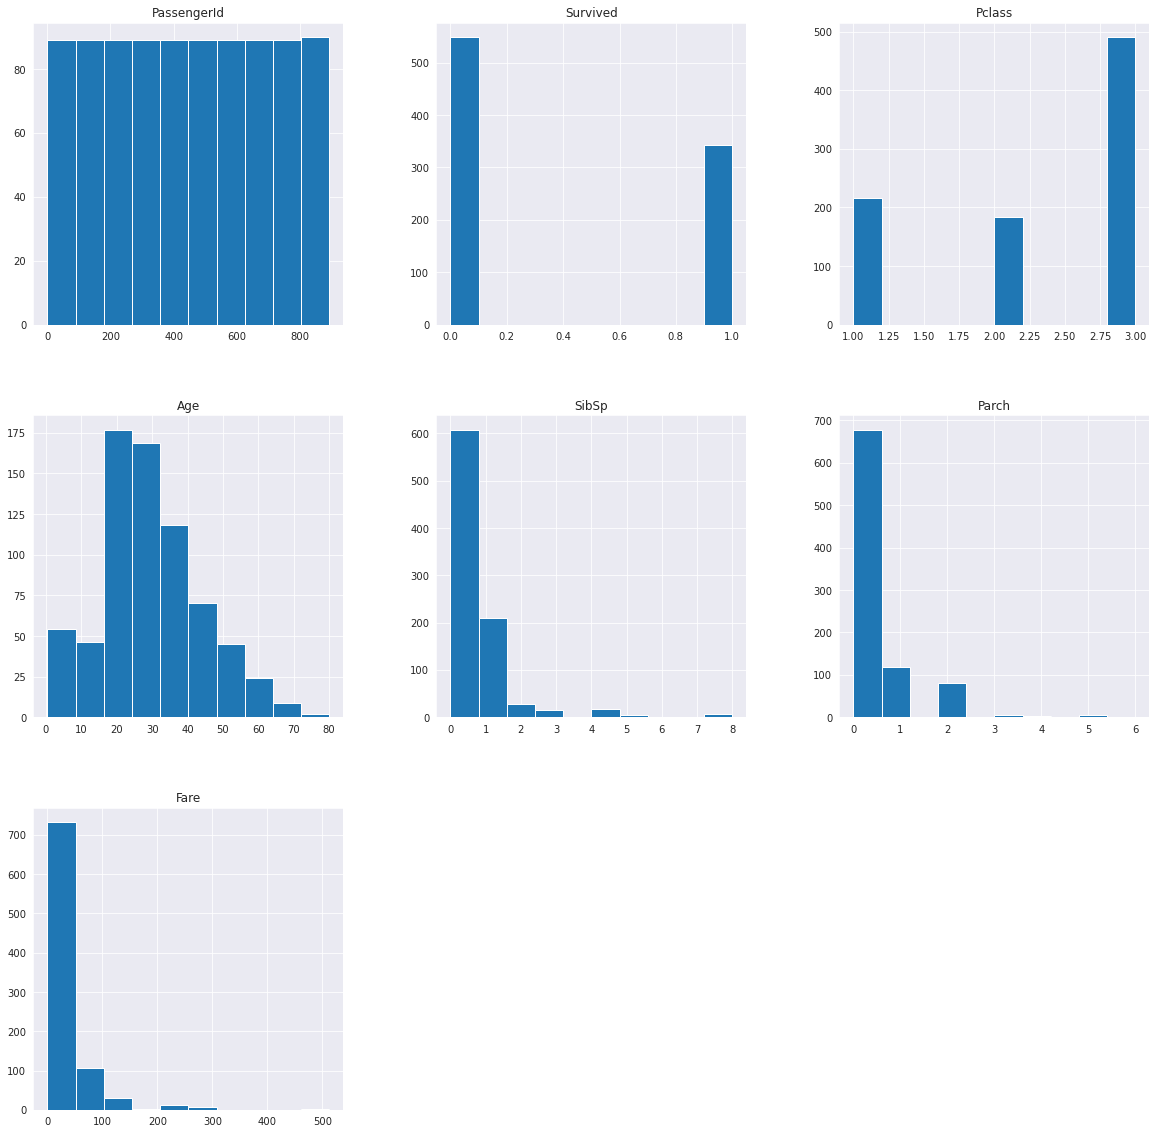

In [10]:
#dataset_train.plot(kind='density', subplots=True, layout=(4,2), sharex=False, figsize=(20,20))
dataset_train.hist(figsize=(20,20));

### Preliminary infos we can get from the histogram plots
- Most people traveled alone (SibSp and Parch). <br>
- Most people paid a fare less than $50. <br>
- There is some very young children amongst the passengers. <br>
- There is approximately the same amount of passengers in class 1 and 2. <br>

Let's dive now a bit further in the features and how they affect the survival rate.

# 3. Feature exploratory analysis

What we would like to analyse :
- The correlation of age and survivability
- The correlation of sex and survivability
- The correlation of the class and survivability
- The correlation of the fare and survivability
- The correlation of the port of embarquation and survivability
- Does the number of siblings or parents/children has an impact on survivability.
- Who paid 0 and $512 for their ticket?

## Let's look at the three categorical features (sex, embarked and Pclass)

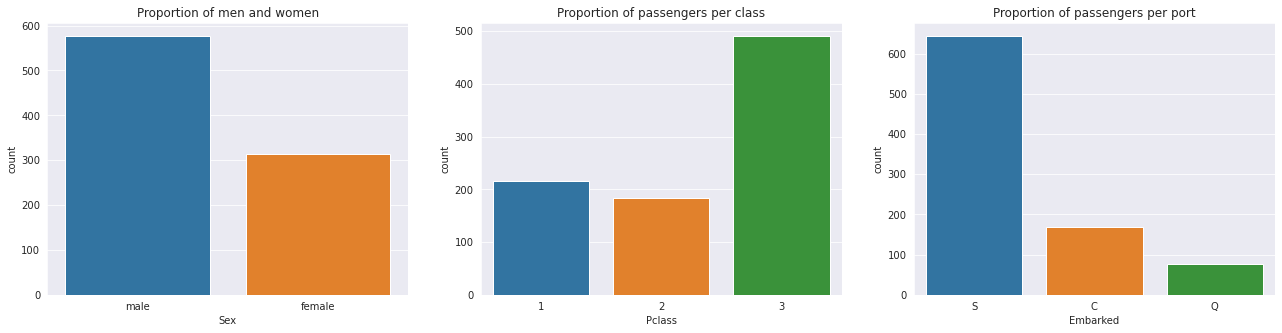

In [11]:
fig, ax = plt.subplots(1,3, figsize=(22,5))
sns.countplot(x="Sex", data=dataset_train, ax=ax[0])
ax[0].set_title('Proportion of men and women');
sns.countplot(x="Pclass", data=dataset_train, ax=ax[1])
ax[1].set_title('Proportion of passengers per class');
sns.countplot(x="Embarked", data=dataset_train, ax=ax[2])
ax[2].set_title('Proportion of passengers per port');

There is a more men than women and most of the passengers embarked at the Southampton port.
Most passengers are in class 3.

Now let's check if these features have an impact on the survival rate.

In [12]:
dataset_train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [13]:
dataset_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [14]:
dataset_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


### What can we learn from the previous statistics?
- Women had almost 4 times more chance to survive than men
- The passengers in class 1 and 2 ahd a better chance of surviving compare to passengers in class 3
- People that embarked in the port C had a better chance of surviving.
    - We can probably check if people from port C belong to class number 1 and 2 which might explain the increase in survival rate.

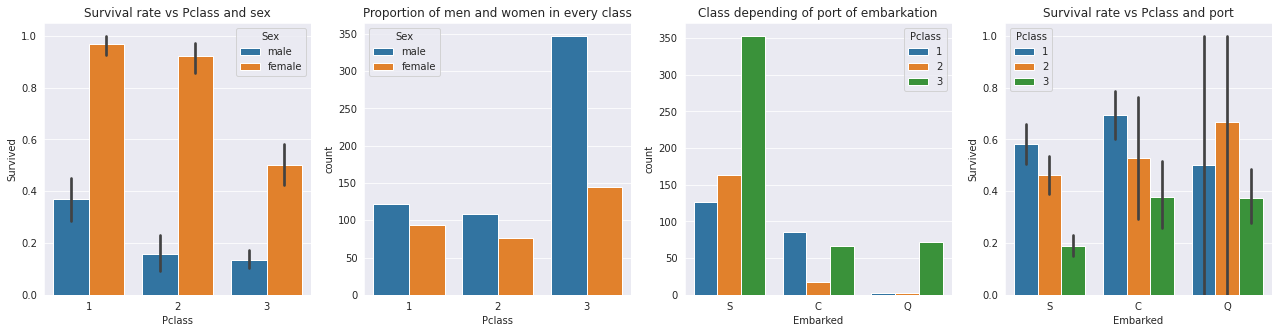

In [15]:
fig, ax = plt.subplots(1,4, figsize=(22,5))
sns.barplot(x="Pclass", y="Survived", hue="Sex", data=dataset_train, ax=ax[0])
ax[0].set_title('Survival rate vs Pclass and sex');
sns.countplot(x="Pclass", hue="Sex", data=dataset_train, ax=ax[1])
ax[1].set_title('Proportion of men and women in every class');
sns.countplot(x="Embarked", hue="Pclass", data=dataset_train, ax=ax[2])
ax[2].set_title('Class depending of port of embarkation');
sns.barplot(x="Embarked", y="Survived", hue="Pclass", data=dataset_train, ax=ax[3])
ax[3].set_title('Survival rate vs Pclass and port');

### What can we learn from the previous plots?
- Women in class number 1 and 2 had a very high chance of surviving.
- A lot of people from class number 3 were men whereas in class 1 and 2 it was almost the same number and men and women.
- Very few people in class 1 and 2 embarqued in port Q which explains the very high std for the survival rate.
- Interestingly, people from class number 3 had a better chance of surviving if they embarqued in port C and Q.

## Let's now look at the family size and if it has an impact on survival

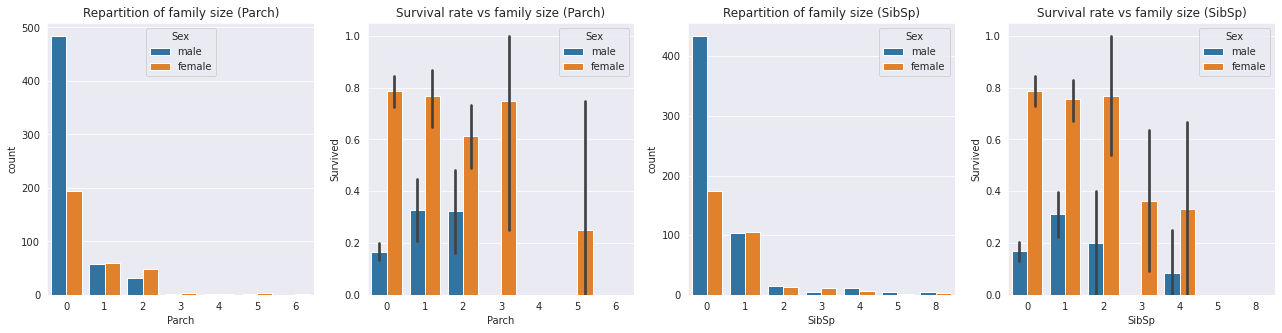

In [16]:
fig, ax = plt.subplots(1,4, figsize=(22,5))
sns.countplot(x="Parch", hue="Sex", data=dataset_train, ax=ax[0])
ax[0].set_title('Repartition of family size (Parch)');
sns.barplot(x="Parch", y="Survived", hue="Sex", data=dataset_train, ax=ax[1])
ax[1].set_title('Survival rate vs family size (Parch)');
sns.countplot(x="SibSp", hue="Sex", data=dataset_train, ax=ax[2])
ax[2].set_title('Repartition of family size (SibSp)');
sns.barplot(x="SibSp", y="Survived", hue="Sex", data=dataset_train, ax=ax[3])
ax[3].set_title('Survival rate vs family size (SibSp)');

### What can we learn from the previous plots?
- Most people travelled alone, especially men.
- As a man, you have better chance of surviving if you are travelling with someone.

It seems interesting to build a new feature with family size.

## Let's look how the age and survival rate are related

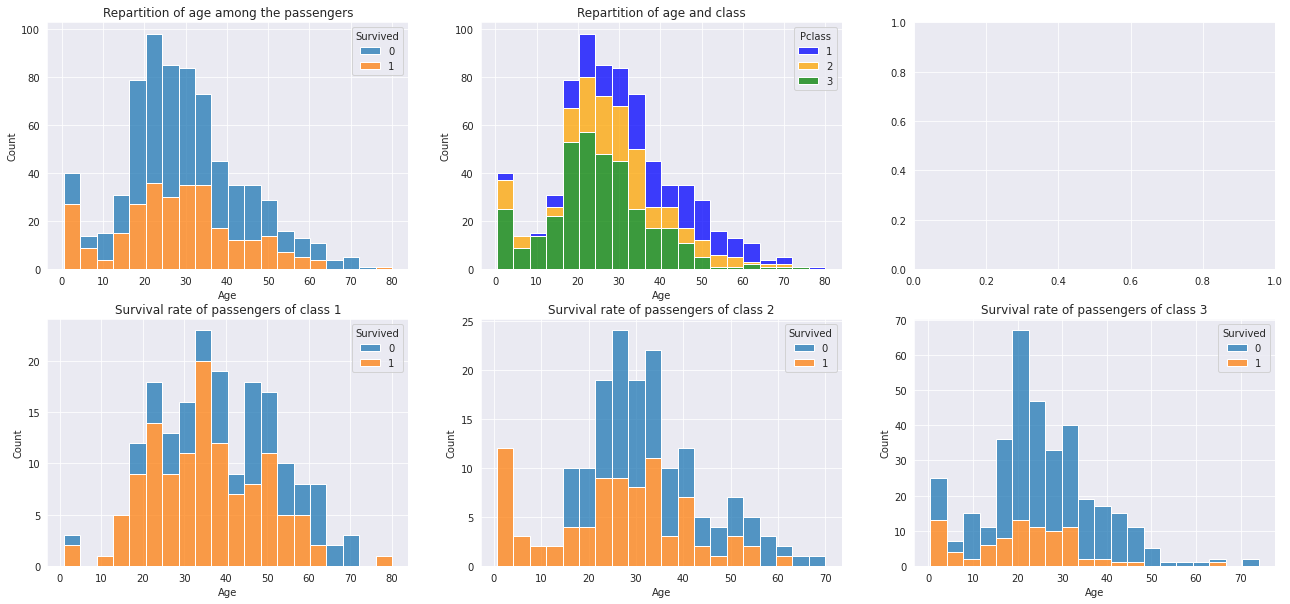

In [17]:
bin_size = 20
fig, ax = plt.subplots(2,3, figsize=(22,10))
sns.histplot(data=dataset_train, x="Age", hue="Survived", multiple="stack", bins=bin_size, ax=ax[0][0])
ax[0][0].set_title('Repartition of age among the passengers');
sns.histplot(x="Age", hue="Pclass", data=dataset_train, ax=ax[0][1],multiple="stack", bins=bin_size, palette=['blue', 'orange', 'green'])
ax[0][1].set_title('Repartition of age and class');
sns.histplot(x="Age", hue="Survived", multiple="stack", bins=bin_size, data=dataset_train.loc[dataset_train['Pclass'] == 1], ax=ax[1][0])
ax[1][0].set_title('Survival rate of passengers of class 1');
sns.histplot(x="Age", hue="Survived", multiple="stack", bins=bin_size, data=dataset_train.loc[dataset_train['Pclass'] == 2], ax=ax[1][1])
ax[1][1].set_title('Survival rate of passengers of class 2');
sns.histplot(x="Age", hue="Survived", multiple="stack", bins=bin_size, data=dataset_train.loc[dataset_train['Pclass'] == 3], ax=ax[1][2])
ax[1][2].set_title('Survival rate of passengers of class 3');

### What can we learn from the previous plots?
- Children less than 15 years old in the class 1 and 2 had a very high chance of surviving
- Older people (more than 45) had a lower chance of surviving
- For passengers of class 3, the age did not really help surviving.
- Class 1 and 2 have more older people than class 3.

## Let's look at the fare and maybe the fare per person.

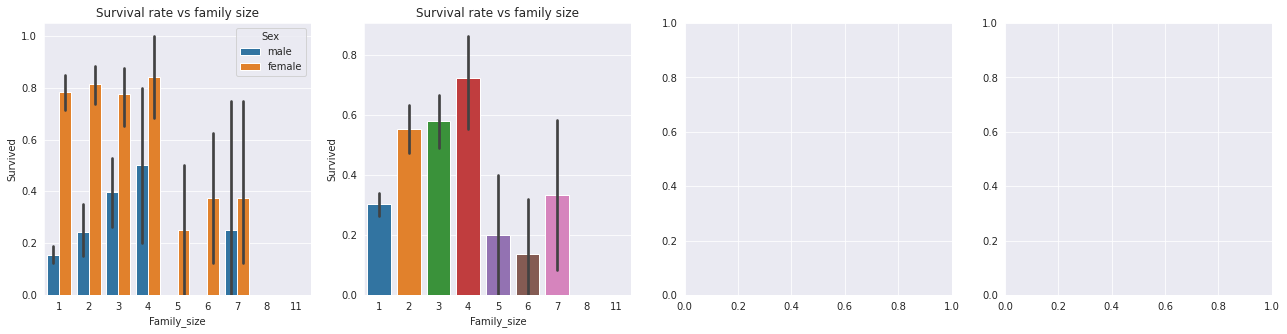

In [18]:
#Let's first create a family size column and then a fare per person column.
df = dataset_train.copy()
df['Family_size'] = df['Parch']+df['SibSp']+1
df['Fare_per_person'] = df['Fare']/df['Family_size']
#Let's also reduce the maximum fare per person at 60 to avoid extreme values.
df.loc[df['Fare_per_person'] >= 60, 'Fare_per_person']=60
fig, ax = plt.subplots(1,4, figsize=(22,5))
sns.barplot(x="Family_size", y="Survived", hue="Sex", data=df, ax=ax[0])
ax[0].set_title('Survival rate vs family size');
sns.barplot(x="Family_size", y="Survived", data=df, ax=ax[1])
ax[1].set_title('Survival rate vs family size');

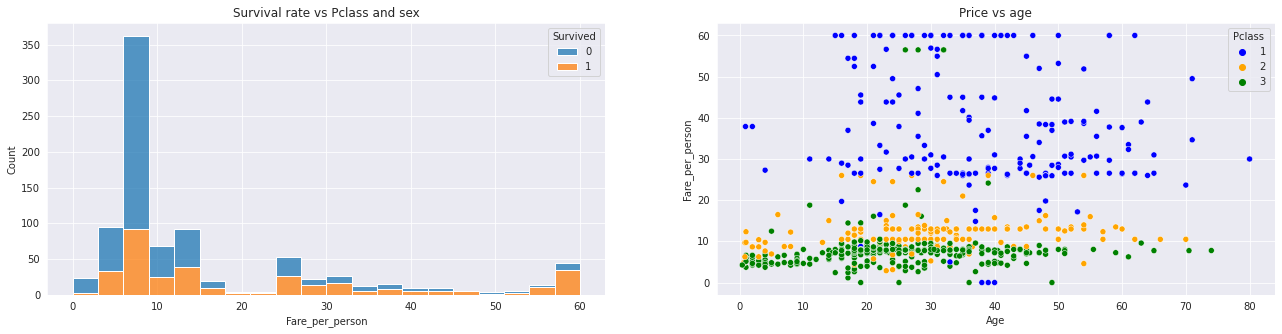

In [19]:
fig, ax = plt.subplots(1,2, figsize=(22,5))
sns.histplot(data=df, x='Fare_per_person', hue="Survived", multiple="stack", bins=20, ax=ax[0])
ax[0].set_title('Survival rate vs Pclass and sex');
sns.scatterplot(x="Age", y="Fare_per_person", hue="Pclass", data=df, ax=ax[1], palette=['blue', 'orange', 'green'])
ax[1].set_title('Price vs age');

### What can we learn from these plots?
- A higher fare meant a higher chance of surviving
- Somme people from class 1 (and 3) paid 0 or close to 0, it might indicate missing values.
- Three people from class 3 paid more than $50 for their ticket, it might also be an error.

In [20]:
df.loc[df['Fare_per_person'] <= 1]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_size,Fare_per_person
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S,1,0.0
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S,1,0.0
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S,1,0.0
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S,1,0.0
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S,1,0.0
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S,1,0.0
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S,1,0.0
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S,1,0.0
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S,1,0.0
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S,1,0.0


We need to recalculate the price of their ticket based on their class.

In [21]:
df.loc[(df['Fare_per_person'] > 50) & (df['Pclass'] == 3)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_size,Fare_per_person
74,75,1,3,"Bing, Mr. Lee",male,32.0,0,0,1601,56.4958,NaN,S,1,56.4958
169,170,0,3,"Ling, Mr. Lee",male,28.0,0,0,1601,56.4958,NaN,S,1,56.4958
509,510,1,3,"Lang, Mr. Fang",male,26.0,0,0,1601,56.4958,NaN,S,1,56.4958
643,644,1,3,"Foo, Mr. Choong",male,NaN,0,0,1601,56.4958,NaN,S,1,56.4958
692,693,1,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S,1,56.4958
826,827,0,3,"Lam, Mr. Len",male,NaN,0,0,1601,56.4958,NaN,S,1,56.4958
838,839,1,3,"Chip, Mr. Chang",male,32.0,0,0,1601,56.4958,NaN,S,1,56.4958


These people have the same ticket number but don't belong to the same family. <br>
We need to investigate if the family size is equal to the number of ticket with the same number. <br>
It's possible that some family have not been registered.

# 4. Data cleaning and feature selection

Based on previous analysis, the first step will be to create a new column with the number of identical tickets. <br>

In [22]:
#let's create a column with number of identical tickets.
df['Nb_identical_tickets'] = 0
val_counts_ticket = df['Ticket'].value_counts()
for ticket in val_counts_ticket.index.to_list():
    df.loc[df['Ticket'] == ticket, 'Nb_identical_tickets'] = val_counts_ticket[ticket]

In [23]:
#Let's checl if the family size and the number of identical tickets is equivalent or not.
df.loc[(df['Nb_identical_tickets'] - df['Family_size']) >= 2].sort_values('Ticket').head(50)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_size,Fare_per_person,Nb_identical_tickets
759,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5000,B77,S,1,60.0000,3
257,258,1,1,"Cherry, Miss. Gladys",female,30.0,0,0,110152,86.5000,B77,S,1,60.0000,3
504,505,1,1,"Maioni, Miss. Roberta",female,16.0,0,0,110152,86.5000,B79,S,1,60.0000,3
708,709,1,1,"Cleaver, Miss. Alice",female,22.0,0,0,113781,151.5500,NaN,S,1,60.0000,4
627,628,1,1,"Longley, Miss. Gretchen Fiske",female,21.0,0,0,13502,77.9583,D9,S,1,60.0000,3
509,510,1,3,"Lang, Mr. Fang",male,26.0,0,0,1601,56.4958,NaN,S,1,56.4958,7
692,693,1,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S,1,56.4958,7
643,644,1,3,"Foo, Mr. Choong",male,NaN,0,0,1601,56.4958,NaN,S,1,56.4958,7
826,827,0,3,"Lam, Mr. Len",male,NaN,0,0,1601,56.4958,NaN,S,1,56.4958,7
838,839,1,3,"Chip, Mr. Chang",male,32.0,0,0,1601,56.4958,NaN,S,1,56.4958,7


From this analysis we can see that:
- We need to update the fare_per_person in the way : fare_per_person = fare/Nb_identical_tickets

Further questions:
- Do people from the same ticket but not from the same family survive better than people alone?

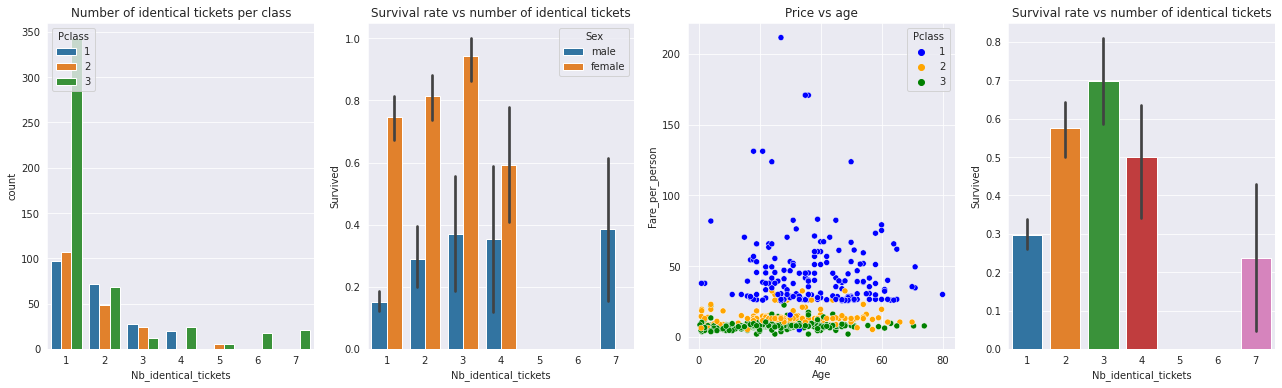

In [24]:
for pclass in df['Pclass'].unique():
    df.loc[(df['Fare'] == 0) & (df['Pclass'] == pclass), 'Fare'] = df.loc[df['Pclass'] == pclass]['Fare'].median()
df['Fare_per_person'] = df['Fare']/df['Nb_identical_tickets']


fig, ax = plt.subplots(1,4, figsize=(22,6))
sns.countplot(x="Nb_identical_tickets", hue="Pclass", data=df, ax=ax[0])
ax[0].set_title('Number of identical tickets per class');
sns.barplot(x="Nb_identical_tickets", y="Survived", hue="Sex", data=df, ax=ax[1])
ax[1].set_title('Survival rate vs number of identical tickets');
sns.scatterplot(x="Age", y="Fare_per_person", hue="Pclass", data=df, ax=ax[2], palette=['blue', 'orange', 'green'])
ax[2].set_title('Price vs age');
sns.barplot(x="Nb_identical_tickets", y="Survived", data=df, ax=ax[3])
ax[3].set_title('Survival rate vs number of identical tickets');

In [25]:
df.loc[(df['Fare_per_person'] <= 25) & (df['Pclass'] == 1)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_size,Fare_per_person,Nb_identical_tickets
270,271,0,1,"Cairns, Mr. Alexander",male,NaN,0,0,113798,31.0,NaN,S,1,15.5,2
842,843,1,1,"Serepeca, Miss. Augusta",female,30.0,0,0,113798,31.0,NaN,C,1,15.5,2
872,873,0,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0,B51 B53 B55,S,1,5.0,1


### What can we learn from this?
- The age is not correlated to the fare per person.
- The number of identical tickets is probably an interesting feature.

Let's create a feature with the title contained in the name and a feature with the cabin letter.

In [26]:
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df['Cabin_level'] = df['Cabin'].astype(str).str[0]

In [27]:
df['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Col           2
Major         2
Mme           1
Capt          1
Jonkheer      1
Countess      1
Sir           1
Lady          1
Don           1
Ms            1
Name: Title, dtype: int64

In [28]:
df['Cabin_level'].value_counts()

n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin_level, dtype: int64

### From these two new columns
- Most cabin are not indicated in the dataset
- There is lot of title that correspond to only one or two persons. We can aggregate them together.
- It would be interesting to check if there is a link between cabin level and class.

In [29]:
df['Title'] = df['Title'].replace(['Capt', 'Col', 'Dr', 'Major', 'Jonkheer', 'Dona'], 'Other')
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')
df['Title'] = df['Title'].replace('Lady', 'Mrs')
df['Title'] = df['Title'].replace('Don', 'Mr')
df['Title'] = df['Title'].replace('Rev', 'Mr')
df['Title'] = df['Title'].replace('Sir', 'Mr')
df['Title'] = df['Title'].replace('Countess', 'Mrs')

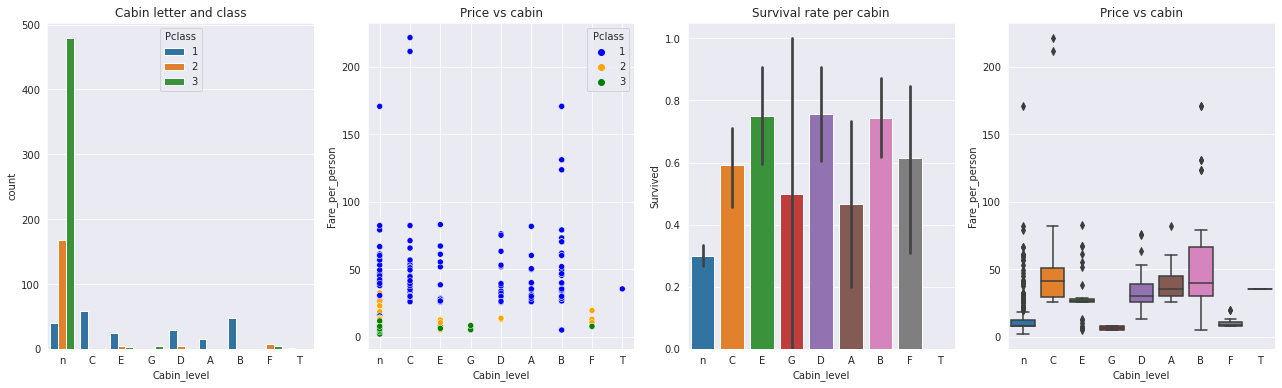

In [30]:
fig, ax = plt.subplots(1,4, figsize=(22,6))
sns.countplot(x="Cabin_level", hue="Pclass", data=df, ax=ax[0])
ax[0].set_title('Cabin letter and class');
sns.scatterplot(x="Cabin_level", y="Fare_per_person", hue="Pclass", data=df, ax=ax[1], palette=['blue', 'orange', 'green'])
ax[1].set_title('Price vs cabin');
sns.barplot(x="Cabin_level", y="Survived", data=df, ax=ax[2])
ax[2].set_title('Survival rate per cabin');
sns.boxplot(x="Cabin_level", y="Fare_per_person", data=df, ax=ax[3])
ax[3].set_title('Price vs cabin');

### What can we learn from the cabin letter?
- Most passengers in cabin A, B, C, D and E were from class number 1.
- Cabins in A, B, C, D and E were the most expensive.
- Cabins F an G were significantly less expensive.
- Cabin T only has one passenger so we cannot really conclude anything from it.
- Women in cabins B, C, D, E and F survived better than other women.

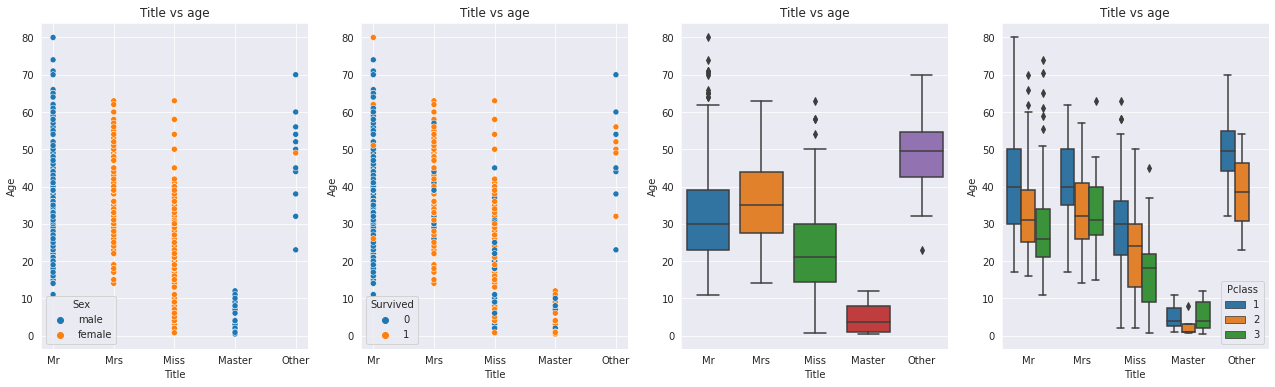

In [31]:
fig, ax = plt.subplots(1,4, figsize=(22,6))
sns.scatterplot(x="Title", y="Age", hue="Sex", data=df, ax=ax[0])
ax[0].set_title('Title vs age');
sns.scatterplot(x="Title", y="Age", hue="Survived", data=df, ax=ax[1])
ax[1].set_title('Title vs age');
sns.boxplot(x="Title", y="Age", data=df, ax=ax[2])
ax[2].set_title('Title vs age');
sns.boxplot(x="Title", y="Age", hue="Pclass", data=df, ax=ax[3])
ax[3].set_title('Title vs age');

Let's also see if mother and children had a better chance of survival
- Children are pasengers less than 18 years old
- Mother are passengers that are women, that are more than 22 years old, that have one or more Parch and that have the title Mrs.

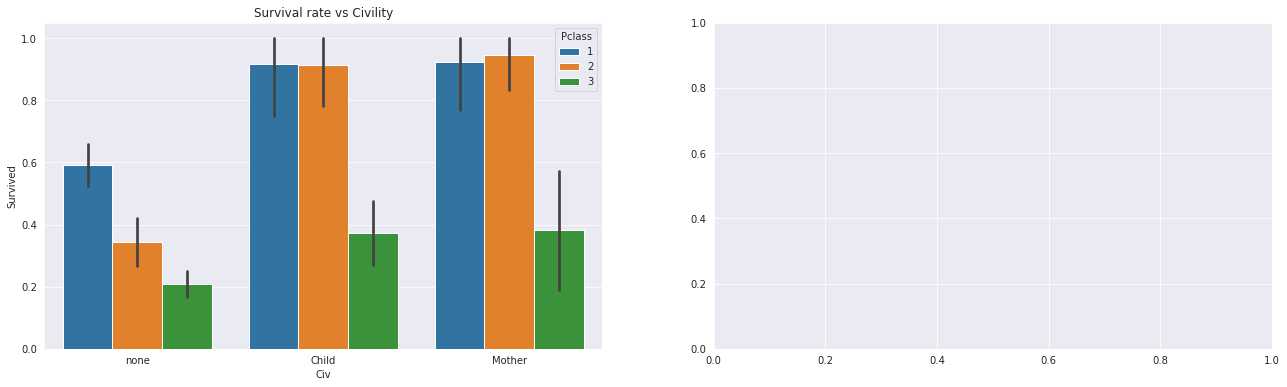

In [32]:
df['Civ'] = 'none'
df.loc[df['Age'] < 18, 'Civ'] = 'Child'
df.loc[(df['Age'] > 18) & (df['Sex'] == 'female') & (df['Title'] == 'Mrs') & (df['Parch'] >= 1), 'Civ'] = 'Mother'
fig, ax = plt.subplots(1,2, figsize=(22,6))
sns.barplot(x="Civ", y="Survived", hue="Pclass", data=df, ax=ax[0])
ax[0].set_title('Survival rate vs Civility');

### What can we learn from this title analysis?
- The title and the class can give an approximation of the age of a person, this can be used to fill the age missing value.
- Children and mother in class 1 and 2 survived really well.

In [33]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_size,Fare_per_person,Nb_identical_tickets,Title,Cabin_level,Civ
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,7.2500,1,Mr,n,none
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,71.2833,1,Mrs,C,none
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,7.9250,1,Miss,n,none
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,26.5500,2,Mrs,C,none
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,8.0500,1,Mr,n,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,1,13.0000,1,Mr,n,none
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1,30.0000,1,Miss,B,none
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,4,11.7250,2,Miss,n,none
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,1,30.0000,1,Mr,C,none


## 4.2 Preprocessing pipeline

Steps to include in the preprocessing pipeline:
- Feature engineering
    - Create a title column
    - Create a family size (Parch + SibSp + 1)
    - Create a nb of identical tickets column
    - Create a Civ column for children and mother
    - Create a Deck column with the first letter of the cabin
- Impute missing values
    - For Fare : median value of the passengers of the same class
    - For Age : median value of the passenger of the same title and class
- Encode feature
    - Family size will be encoded in three subcategories (single (<2), small (>1 & < 5) and large (>5)
    - Deck will be encoded in three subcategories (BDE, CF, AG)
    - Number of identical tickets will become ident_tickets_234 with passengers with the same ticket as up to 3 passengers have a better chance of surviving
- Binning of features
    - Age : 0-6, 7-12, 13-17, 18-25, 26-40, 41-100
    - Fare per person : 0-5, 5-10, 10-15, 15-25, 25-40, 40-100
- Scale features (robust scaler)
- Remove feature (PassengerId, Name, SibSp, Parch, Ticket, Fare, Embarked)

In [34]:
#Preprocessing functions definition
def extract_deck(df):
    df['Cabin'] = df['Cabin'].astype(str).str[0]
    return df

def encode_deck(df):
    df['Deck_BDE'] = 0
    df['Deck_CF'] = 0
    df['Deck_AG'] = 0
    df.loc[(df['Cabin'] == 'B') | (df['Cabin'] == 'D') | (df['Cabin'] == 'E'), 'Deck_BDE'] = 1
    df.loc[(df['Cabin'] == 'C') | (df['Cabin'] == 'F'), 'Deck_CF'] = 1
    df.loc[(df['Cabin'] == 'A') | (df['Cabin'] == 'G'), 'Deck_AG'] = 1
    return df

def encode_family_size(df):
    df.loc[(df['Family_size'] > 1) & (df['Family_size'] < 5), 'Family_size'] = 2
    df.loc[df['Family_size'] > 4, 'Family_size'] = 3
    return df

def encode_identical_tickets(df):
    df['Ident_tickets_234'] = 0
    df.loc[(df['Nb_identical_tickets'] > 1) & (df['Nb_identical_tickets'] < 5), 'Ident_tickets_234'] = 1
    return df

def extract_title(df):
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(['Capt', 'Col', 'Dr', 'Major', 'Jonkheer', 'Dona'], 'Other')
    df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
    df['Title'] = df['Title'].replace(['Mme', 'Lady', 'Countess'], 'Mrs')
    df['Title'] = df['Title'].replace(['Don', 'Rev', 'Sir'], 'Mr')
    return df

def extract_family_size(df):
    df['Family_size'] = df['Parch'] + df['SibSp'] + 1
    return df

def extract_identical_tickets(df):
    df['Nb_identical_tickets'] = 0
    val_counts_ticket = df['Ticket'].value_counts()
    for ticket in val_counts_ticket.index.to_list():
        df.loc[df['Ticket'] == ticket, 'Nb_identical_tickets'] = val_counts_ticket[ticket]
    return df

def calculate_fare_per_person(df):
    df['Fare_per_person'] = df['Fare']/df['Nb_identical_tickets']
    return df

def impute_fare(df, df_total):
    for pclass in df['Pclass'].unique():
        df.loc[((df['Fare'].isna()) | (df['Fare'] == 0)) & (df['Pclass'] == pclass), 'Fare'] = df_total.loc[df_total['Pclass'] == pclass]['Fare'].median()
    return df

def impute_age(df, df_total):
    for pclass in df['Pclass'].unique():
        for title in df.loc[df['Pclass'] == pclass]['Title'].unique():
            df.loc[(df['Pclass'] == pclass) & (df['Title'] == title) & (df['Age'].isna()), 'Age'] = df_total.loc[(df_total['Pclass'] == pclass) & (df_total['Title'] == title)]['Age'].median()
            #print(title, pclass, df.loc[(df['Pclass'] == pclass) & (df['Title'] == title)]['Age'].median())
    return df

def bin_column(df, col, bins, labels):
    df[col] = pd.cut(df[col], bins=bins, labels=labels)
    df[col] = df[col].astype(float)
    return df

def extract_civ(df):
    df['Child'] = 0
    df['Mother'] = 0
    df.loc[df['Age'] < 18, 'Child'] = 1
    df.loc[(df['Age'] > 18) & (df['Sex'] == 'female') & (df['Title'] == 'Mrs') & (df['Parch'] >= 1), 'Mother'] = 1
    return df

In [35]:
dataset_train = pd.read_csv("/kaggle/input/titanic/train.csv").drop(columns=['Survived'])
dataset_test = pd.read_csv("/kaggle/input/titanic/test.csv")

combine = [dataset_train, dataset_test]
for df in combine:
    df = extract_title(df)
    df = extract_family_size(df)
    df = extract_identical_tickets(df)
    df = extract_civ(df)
    df = extract_deck(df)
    df = impute_fare(df, dataset_train)
    df = impute_age(df, dataset_train)
    df = calculate_fare_per_person(df)
    df = encode_family_size(df)
    df = encode_deck(df)
    df = encode_identical_tickets(df)
    df = bin_column(df, 'Fare_per_person', bins=[0,5,10,15,25,40,1000], labels=[1,2,3,4,5,6])
    df = bin_column(df, 'Age', bins=[0,6,12,17,25,40,100], labels=[1,2,3,4,5,6])

In [36]:
dataset_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PassengerId           418 non-null    int64  
 1   Pclass                418 non-null    int64  
 2   Name                  418 non-null    object 
 3   Sex                   418 non-null    object 
 4   Age                   418 non-null    float64
 5   SibSp                 418 non-null    int64  
 6   Parch                 418 non-null    int64  
 7   Ticket                418 non-null    object 
 8   Fare                  418 non-null    float64
 9   Cabin                 418 non-null    object 
 10  Embarked              418 non-null    object 
 11  Title                 418 non-null    object 
 12  Family_size           418 non-null    int64  
 13  Nb_identical_tickets  418 non-null    int64  
 14  Child                 418 non-null    int64  
 15  Mother                4

In [37]:
#Preprocessing pipeline
drop_cols = ['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked', 'Nb_identical_tickets', 'Cabin']
num_cols = ['Pclass', 'Age', 'Family_size', 'Child', 'Mother', 'Fare_per_person', 'Deck_BDE', 'Deck_CF', 'Deck_AG', 'Ident_tickets_234']
preprocessing = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore', sparse=False) , ['Title']),
    (OneHotEncoder(handle_unknown='ignore', sparse=False) , ['Sex']),
    ('drop' ,                                               drop_cols),
    remainder = "passthrough"
)

## 5. Model Preparation

In [38]:
#dataset_train = pd.read_csv("/kaggle/input/titanic/train.csv")
X = dataset_train
y = np.ravel(np.array([pd.read_csv("/kaggle/input/titanic/train.csv")['Survived']]).T)

X_pred = dataset_test.copy()

folds = KFold(n_splits=10, shuffle=True, random_state=0)

### Let's see how the dataset looks like after the preprocessing phase

In [45]:
pipeline = Pipeline([
    ('preprocessing' , preprocessing),
    ('scaler' ,        MinMaxScaler())
])
pipeline.fit(X)
pd.DataFrame(pipeline.transform(X)).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.044893,0.207632,0.589226,0.143659,0.014590,0.352413,0.647587,0.654321,0.703479,0.233446,0.126824,0.058361,0.415039,0.125701,0.080808,0.021324,0.331089
std,0.207186,0.405840,0.492251,0.350940,0.119973,0.477990,0.477990,0.418036,0.246912,0.311653,0.332962,0.234557,0.295583,0.331699,0.272693,0.144544,0.470869
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.600000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.800000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.800000,0.500000,0.000000,0.000000,0.800000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Let's test many different algorithm

In [43]:
models_list = { 'LogisticRegression': LogisticRegression(), 
           'SVC': SVC(),
           'LinearSVC': LinearSVC(), 
           'Random Forest': RandomForestClassifier(), 
           'KNN': KNeighborsClassifier(), 
           'Naive Bayes' :GaussianNB(), 
           'Perceptron': Perceptron(), 
           'SGD': SGDClassifier(), 
           'Decision tree': DecisionTreeClassifier(),
           'XGBoost': xgb.XGBClassifier(use_label_encoder=False, verbosity = 0)}

model_perf_matrix = []
for model_name, model in models_list.items():
    pipeline = Pipeline([
        ('preprocessing' , preprocessing),
        ('scaler' ,        MinMaxScaler()),
        ('model' ,           model)
    ])

    cv_score = cross_val_score(pipeline, X, y, cv=folds);
    model_perf_matrix.append([model_name, round(cv_score.mean(),3), round(cv_score.std(),4)])
    
df_model_perf = pd.DataFrame(model_perf_matrix, columns=['Model', 'Mean value', 'Std value'])
df_model_perf

,Model,Mean value,Std value
0,LogisticRegression,0.824,0.0321
1,SVC,0.826,0.0210
2,LinearSVC,0.826,0.0240
3,Random Forest,0.816,0.0314
4,KNN,0.788,0.0412
5,Naive Bayes,0.771,0.0391
6,Perceptron,0.771,0.0744
7,SGD,0.797,0.0438
8,Decision tree,0.808,0.0244
9,XGBoost,0.823,0.0166


### Let's now test the five best algorithms with hyperparameters tuning

# START HERE

In [47]:
pipeline_preprocessing = Pipeline([
    ('preprocessing' , preprocessing),
    ('scaler' ,        MinMaxScaler())
])
pipeline_preprocessing.fit(X)
X_preprocessed = pd.DataFrame(pipeline_preprocessing.transform(X))
y = np.ravel(np.array([pd.read_csv("/kaggle/input/titanic/train.csv")['Survived']]).T)

In [64]:
models_list = { 'LogisticRegression': { 'model' : LogisticRegression(),
                                         'param_grid' : { 
                                                            'C'     : [0.001, 0.01, 0.1, 1.]
                                                         }},
                                'SVC': { 'model' : SVC(),
                                         'param_grid' : { 
                                                            "C": [0.001, 0.01, 0.1, 1.],
                                                            "kernel": ["linear", "poly", "rbf", "sigmoid"],
                                                            "gamma": ["scale", "auto"]
                                                         }},
                                'LinearSVC': { 'model' : LinearSVC(),
                                         'param_grid' : { 
                                                            'C' : [0.001, 0.01, 0.1, 1.]
                                                         }},
                                'Random Forest': { 'model' : RandomForestClassifier(),
                                         'param_grid' : { 
                                                            'n_estimators': [100, 200, 300],
                                                            'max_features': ['auto', 'sqrt', 'log2'],
                                                            'min_samples_split': [2,4,10],
                                                            'criterion' :['gini', 'entropy']
                                                         }},
                                'XGBoost': { 'model' : xgb.XGBClassifier(use_label_encoder=False, verbosity = 0),
                                         'param_grid' : { 
                                                            'max_depth': [3, 5, 7, 9], 
                                                            'n_estimators': [5, 10, 15, 20, 25, 50, 100],
                                                            'learning_rate': [0.01, 0.05, 0.1]
                                                         }}}

In [72]:
for model_name, model in models_list.items():
    best_model = GridSearchCV(estimator=model['model'], param_grid=model['param_grid'], cv= 10)
    best_model.fit(X_preprocessed, y)
    print(model_name)
    print(best_model.best_params_)
    
#df_model_perf = pd.DataFrame(model_perf_matrix, columns=['Model', 'Mean value', 'Std value'])
#df_model_perf

LogisticRegression
{'C': 1.0}
SVC
{'C': 1.0, 'gamma': 'scale', 'kernel': 'linear'}
LinearSVC
{'C': 0.1}
Random Forest
{'criterion': 'entropy', 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 100}
XGBoost
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


In [70]:
rfc=RandomForestClassifier(random_state=0)
param_grid = { 
    'n_estimators': [100, 200],
    'max_features': ['auto'],
    'min_samples_split': [2,4],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5, verbose=10)
CV_rfc.fit(X_preprocessed, y)
CV_rfc.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5; 1/8] START criterion=gini, max_features=auto, min_samples_split=2, n_estimators=100
[CV 1/5; 1/8] END criterion=gini, max_features=auto, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV 2/5; 1/8] START criterion=gini, max_features=auto, min_samples_split=2, n_estimators=100
[CV 2/5; 1/8] END criterion=gini, max_features=auto, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV 3/5; 1/8] START criterion=gini, max_features=auto, min_samples_split=2, n_estimators=100
[CV 3/5; 1/8] END criterion=gini, max_features=auto, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV 4/5; 1/8] START criterion=gini, max_features=auto, min_samples_split=2, n_estimators=100
[CV 4/5; 1/8] END criterion=gini, max_features=auto, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV 5/5; 1/8] START criterion=gini, max_features=auto, min_samples_split=2, n_estimators=100
[CV 5/5; 1/8] END criterion=gin

{'criterion': 'entropy',
 'max_features': 'auto',
 'min_samples_split': 4,
 'n_estimators': 100}

In [ ]:
#grid_search_cv = GridSearchCV(rfc, param_grid, verbose=10, cv=10)
#grid_search_cv.fit(X, y)
#grid_search_cv.best_params_

In [ ]:
rfc1=RandomForestClassifier(random_state=0, max_features='log2', n_estimators= 200, min_samples_split=2, criterion='entropy')
cv_score = cross_val_score(rfc1, X, y,cv=folds);
print('Accuracy : ', round(cv_score.mean()*100,2), '%')
print('Standard deviation : ', round(cv_score.std()*100,2), '%')

In [ ]:
#dt1=DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=4, max_leaf_nodes=15, min_samples_split= 2)
#dt1.fit(X_train, y_train)
#print(round(rfc1.score(X_test, y_test) * 100, 2))

In [ ]:
rfc1.fit(X,y)
y_pred = rfc1.predict(X_pred).astype(int)
output = pd.DataFrame({'PassengerId': pd.read_csv("/kaggle/input/titanic/test.csv").PassengerId, 'Survived': y_pred})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

In [ ]:
#plt.figure(figsize=(10,8))
#sns.heatmap(X_train.corr(), cmap='RdBu_r', annot=True)
#plt.show()